In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from tqdm import tqdm
import gc
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, ConvLSTM3D, Bidirectional, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
def coordinate_to_matrix(coordinates, grid_size = 25):
    grid_size = grid_size - 1
    matrix = np.zeros((grid_size + 1 , grid_size + 1, grid_size + 1))
    for x, y, z, charge in coordinates:
        x_indx = int(x * grid_size)
        y_indx = int(y * grid_size)
        z_indx = int(z * grid_size)
        matrix[x_indx][y_indx][z_indx] = matrix[x_indx][y_indx][z_indx] + charge
    return matrix

def angular_dist_score(az_true, zen_true, az_pred, zen_pred):
    sa1 = np.sin(az_true)
    ca1 = np.cos(az_true)
    sz1 = np.sin(zen_true)
    cz1 = np.cos(zen_true)
    
    sa2 = np.sin(az_pred)
    ca2 = np.cos(az_pred)
    sz2 = np.sin(zen_pred)
    cz2 = np.cos(zen_pred)
    scalar_prod = sz1*sz2*(ca1*ca2 + sa1*sa2) + (cz1*cz2)
    scalar_prod =  np.clip(scalar_prod, -1, 1)
    return np.average(np.abs(np.arccos(scalar_prod)))

def convert_to_cartesian(azimuth, zenith):
    x = np.sin(zenith) * np.cos(azimuth)
    y = np.sin(zenith) * np.sin(azimuth)
    z = np.cos(zenith)
    return x, y, z

def convert_to_polar(x, y, z):
    r = math.sqrt(x * x + y * y + z * z)
    c = -1 if y < 0 else 1
    azimuth = math.acos(x / math.sqrt(x * x + y * y)) * c
    zenith = math.acos(z / r)
    return azimuth, zenith

def adjust_polar(azimuth, zenith):
    if azimuth < 0:
        azimuth += math.pi * 2
    elif zenith < 0:
        zenith += math.pi
    return azimuth, zenith

In [3]:
sensors_df = pd.read_csv('./data/sensor_geometry.csv')
x_min, x_max, y_min, y_max, z_min, z_max = sensors_df.x.min(), sensors_df.x.max(), sensors_df.y.min(), sensors_df.y.max(), sensors_df.z.min(), sensors_df.z.max()
sensors_df['x'] = (sensors_df['x'] - x_min) / (x_max - x_min)
sensors_df['y'] = (sensors_df['y'] - y_min) / (y_max - y_min)
sensors_df['z'] = (sensors_df['z'] - z_min) / (z_max - z_min)

meta_df = pd.read_parquet('./data/train_meta.parquet')
meta_df[['batch_id', 'event_id', 'first_pulse_index', 'last_pulse_index']] = meta_df[['batch_id', 'event_id', 'first_pulse_index', 'last_pulse_index']].astype(int)
meta_df[['azimuth', 'zenith']] = meta_df[['azimuth', 'zenith']].astype(np.float32)

df = pd.read_parquet('./data/train/batch_1.parquet')
df['auxiliary'] = df['auxiliary'].astype(int)

In [4]:
sample_size = 200000
grid_size = 10
random_state = 42
time_upper = [0.2, 0.4, 0.6, 0.8, 1.0]
time_lower = [0.0, 0.2, 0.4, 0.6, 0.8]
matrix_main = []
target = []

time_steps = len(time_upper)
meta_batch_df = meta_df[meta_df.batch_id == 1]
target_coordinates_df = meta_batch_df[['azimuth', 'zenith']].apply(lambda x: convert_to_cartesian(x[0], x[1]), axis=1, result_type='expand')
meta_batch_df = pd.concat([meta_batch_df, target_coordinates_df], axis=1)
meta_batch_df.rename(columns={0: 'x_target', 1: 'y_target', 2: 'z_target'}, inplace=True)
meta_batch_df = meta_batch_df.sample(meta_batch_df.shape[0], random_state=random_state)
meta_batch_df.reset_index(drop=True, inplace=True)
for indx in tqdm(range(0, sample_size, 1)):
    _, event_id, first_pulse_index, last_pulse_index, azimuth, zenith, target_x, target_y, target_z = meta_batch_df.iloc[indx].values
    df_study = df.iloc[int(first_pulse_index):int(last_pulse_index)].merge(sensors_df, on='sensor_id')
    minimum_time = df_study['time'].min()
    period = df_study['time'].max() - minimum_time
    df_study['time'] = (df_study['time'] - minimum_time) / (period)
    df_study_aux_t = df_study[df_study.auxiliary == 1]
    df_study_aux_f = df_study[df_study.auxiliary == 0]
    
    matrix_final = []
    for time_index in range(time_steps):
        coordinates_t = df_study_aux_t[(df_study_aux_t.time <= time_upper[time_index]) & (df_study_aux_t.time >= time_lower[time_index])][['x', 'y', 'z', 'charge']].values
        matrix_t = coordinate_to_matrix(coordinates_t, grid_size = grid_size)
        
        matrix_t = matrix_t.astype(np.float16)
        coordinates_f = df_study_aux_f[(df_study_aux_f.time <= time_upper[time_index]) & (df_study_aux_f.time >= time_lower[time_index])][['x', 'y', 'z', 'charge']].values
        matrix_f = coordinate_to_matrix(coordinates_f, grid_size = grid_size)
        
        matrix_f = matrix_f.astype(np.float16)
        matrix_final.append([matrix_t, matrix_f])
    
    matrix_main.append(matrix_final)
    target.append([target_x, target_y, target_z])

matrix_main = np.array(matrix_main)
target = np.array(target)

matrix_main.shape, target.shape

100%|██████████| 200000/200000 [21:12<00:00, 157.12it/s]


((200000, 5, 2, 10, 10, 10), (200000, 3))

In [ ]:
for i  in range(0, 10, 1):
    fig = plt.figure(figsize=(20, 10))
    for j in range(time_steps):
        ax = fig.add_subplot(1, time_steps + 1, j+1, projection='3d')
        ax.voxels(matrix_main[i][j][0], edgecolor='k', alpha=0.5, color='r')
        ax.voxels(matrix_main[i][j][1], edgecolor='k', alpha=1, color='b')

    ax = fig.add_subplot(1, time_steps + 1, j+2, projection='3d')
    ax.quiver(0, 0, 0, target[i,0], target[i,1], target[i,2], length=0.03, color = 'black')
    plt.show()

In [5]:
train_p, validation_p = 0.9, 0.05

matrix_train = matrix_main[:int(sample_size * train_p), :, :, :, :, :]
target_train = target[:int(sample_size * train_p), :]

matrix_validation = matrix_main[int(sample_size * train_p):int(sample_size * (train_p + validation_p)), :, :, :, :, :]
target_validation = target[int(sample_size * train_p):int(sample_size * (train_p + validation_p)), :]

matrix_test = matrix_main[int(sample_size * (train_p + validation_p)):, :, :, :, :, :]
target_test = target[int(sample_size * (train_p + validation_p)):, :]

matrix_train.shape, target_train.shape, matrix_validation.shape, target_validation.shape, matrix_test.shape, target_test.shape

((180000, 5, 2, 10, 10, 10),
 (180000, 3),
 (10000, 5, 2, 10, 10, 10),
 (10000, 3),
 (10000, 5, 2, 10, 10, 10),
 (10000, 3))

In [6]:
del matrix_main, target, meta_batch_df, target_coordinates_df, df_study, df_study_aux_t, df_study_aux_f, coordinates_t, matrix_t, coordinates_f, matrix_f, matrix_final
del azimuth, zenith, target_x, target_y, target_z, minimum_time, period, time_upper, time_lower, indx, event_id, first_pulse_index, last_pulse_index
del df, meta_df, sensors_df, sample_size, x_max, x_min, y_max, y_min, z_max, z_min, train_p, validation_p, time_index

gc.collect()

0

In [7]:
def create_model():
    model = Sequential()
    model.add(
        ConvLSTM3D(
            filters=16,
            kernel_size=(1, 1, 1),
            data_format="channels_first",
            input_shape=(time_steps, 2, grid_size, grid_size, grid_size),
            padding="same",
            dropout=0.2,
            return_sequences=True,

        )
    )

    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dropout(0.1))
    model.add(Dense(128, activation="relu"))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(3, activation="linear"))

    return model


model = create_model()


In [8]:
tf.keras.backend.clear_session()
def angular_distance(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true = tf.math.l2_normalize(y_true, axis=1)
    y_pred = tf.math.l2_normalize(y_pred, axis=1)
    return tf.math.acos(tf.reduce_sum(tf.multiply(y_true, y_pred), axis=1))

model.compile(loss=angular_distance, optimizer='adam')
early_stoping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
model.fit(matrix_train, target_train, epochs=500, batch_size=128, validation_data=(matrix_validation, target_validation), callbacks=[early_stoping])

Epoch 1/500
1407/1407 [==============================] - 558s 395ms/step - loss: 1.5337 - val_loss: 1.5404
Epoch 2/500
1407/1407 [==============================] - 561s 399ms/step - loss: 1.5332 - val_loss: 1.5419
Epoch 3/500
1407/1407 [==============================] - 579s 411ms/step - loss: 1.5332 - val_loss: 1.5406
Epoch 4/500
1407/1407 [==============================] - 566s 402ms/step - loss: 1.5332 - val_loss: 1.5405
Epoch 5/500
1407/1407 [==============================] - 556s 395ms/step - loss: 1.5331 - val_loss: 1.5409
Epoch 6/500
1407/1407 [==============================] - 556s 395ms/step - loss: 1.5331 - val_loss: 1.5410
Epoch 7/500
1407/1407 [==============================] - 556s 395ms/step - loss: 1.5331 - val_loss: 1.5408
Epoch 8/500
1407/1407 [==============================] - 556s 395ms/step - loss: 1.5331 - val_loss: 1.5407
Epoch 9/500
1407/1407 [==============================] - 556s 395ms/step - loss: 1.5331 - val_loss: 1.5406
Epoch 10/500
1407/1407 [=============

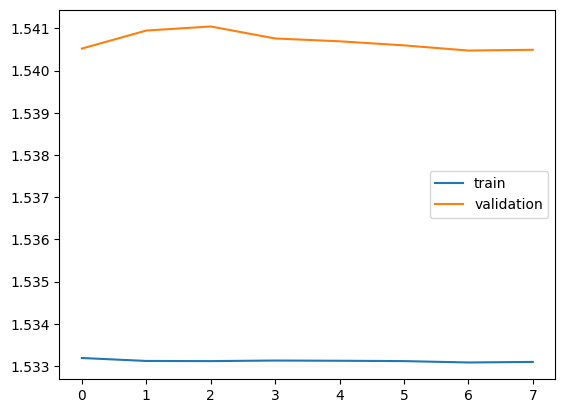

In [9]:
plt.plot(model.history.history['loss'][3:], label='train')
plt.plot(model.history.history['val_loss'][3:], label='validation')
plt.legend()
plt.show()

In [10]:
pred = model.predict(matrix_test)
pred_polar = np.array([convert_to_polar(x, y, z) for x, y, z in pred])
target_test_polar = np.array([convert_to_polar(x, y, z) for x, y, z in target_test])

az_true, zen_true = target_test_polar[:, 0], target_test_polar[:, 1]
az_pred, zen_pred = pred_polar[:, 0], pred_polar[:, 1]

angular_dist_score(az_true, zen_true, az_pred, zen_pred)

313/313 [==============================] - 7s 22ms/step


1.5373053358410804